In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sns.set_theme(style="whitegrid", font_scale=1.1)

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)


In [2]:
franchises = [
    'Star Wars', 'Harry Potter', 'The Matrix',
    'Indiana Jones', 'Jurassic Park',
    'Pirates of the Caribbean', 'Toy Story', 'Batman'
]

# group movies into the different franchises groups 
franchise_groups = {franchise: [] for franchise in franchises}
for index, row in processed_data.iterrows():
    for franchise in franchises:
        if franchise.lower() in row['movie_name'].lower():
            franchise_groups[franchise].append(row)
            break

In [3]:
# create a new dataframe with the franchise groups
franchise_data = []
for franchise, movies in franchise_groups.items():
    if movies:
        franchise_df = pd.DataFrame(movies)
        franchise_df['franchise'] = franchise
        franchise_data.append(franchise_df)

franchise_data = pd.concat(franchise_data, ignore_index=True)
franchise_stats = franchise_data.groupby('franchise')['rating'].agg(['count', 'mean', 'median', 'var', 'std']).reset_index()
franchise_stats.sort_values(by='count', ascending=False, inplace=True)
franchise_stats

,franchise,count,mean,median,var,std
1,Harry Potter,3360,3.304315,3.5,0.728963,0.853793
5,Star Wars,2959,2.856370,3.0,1.095996,1.046898
7,Toy Story,2711,3.241424,3.5,0.732929,0.856113
4,Pirates of the Caribbean,2142,2.887955,3.0,0.901499,0.949473
2,Indiana Jones,1747,2.735547,3.0,0.902819,0.950168
3,Jurassic Park,1697,2.862699,3.0,0.839923,0.916473
0,Batman,1449,2.915459,3.0,1.027551,1.013682
6,The Matrix,1207,2.887324,3.0,0.965320,0.982507


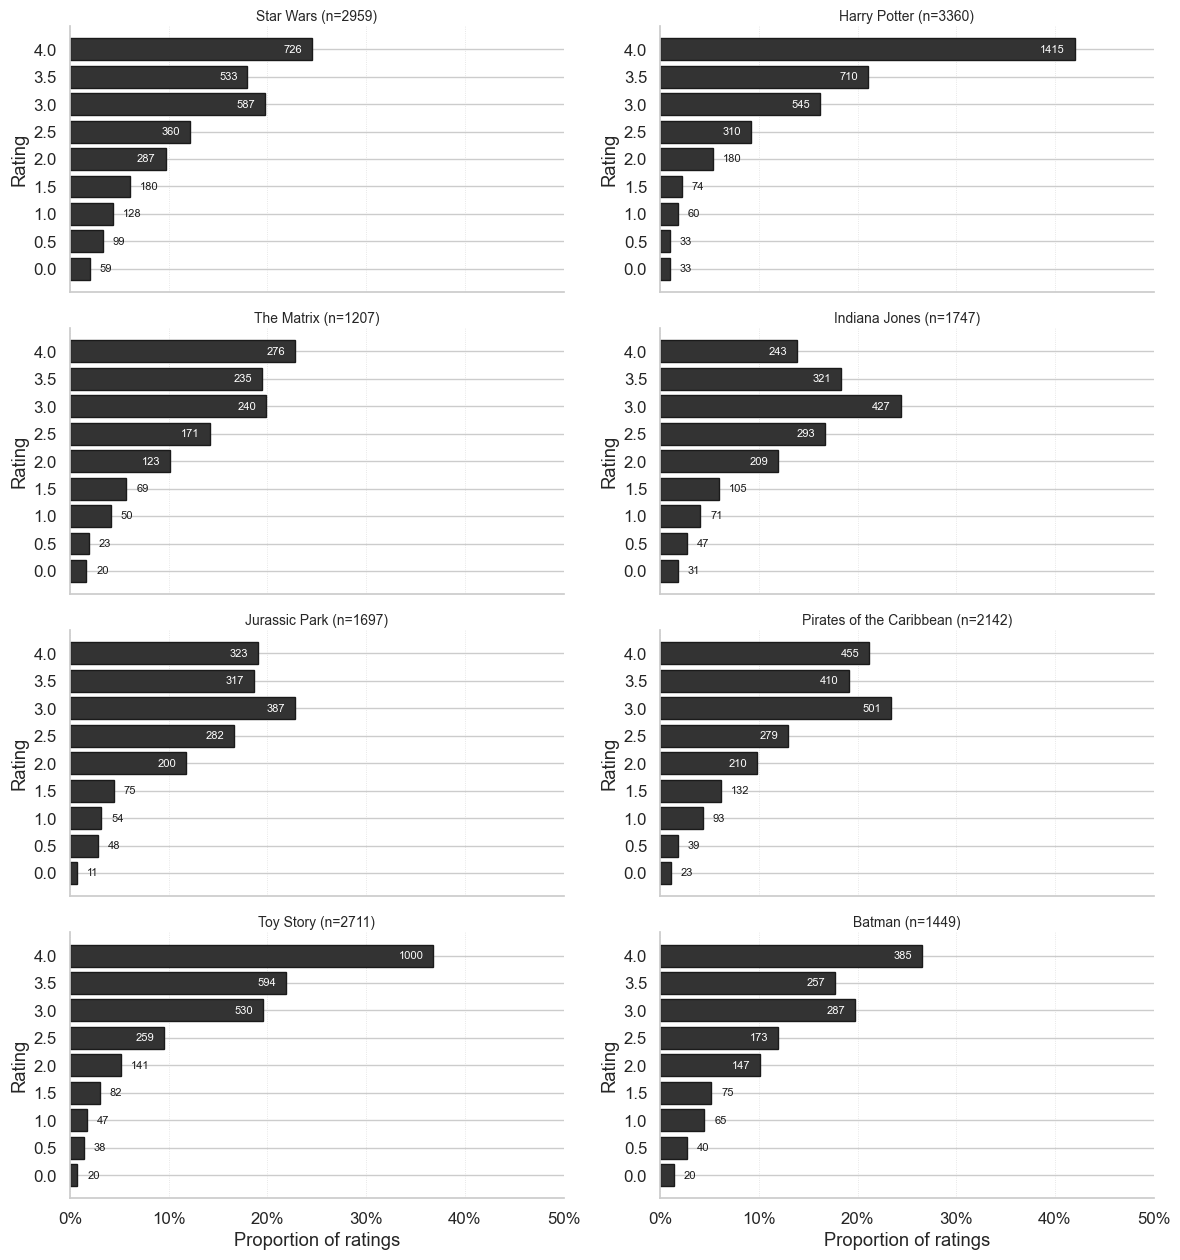

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math

franchises = [
    'Star Wars', 'Harry Potter', 'The Matrix',
    'Indiana Jones', 'Jurassic Park',
    'Pirates of the Caribbean', 'Toy Story', 'Batman'
]

# --- Rating levels (discrete) ---
r_all = franchise_data['rating'].dropna().to_numpy()
r_min, r_max = int(np.floor(r_all.min())), int(np.ceil(r_all.max()))
if not np.isfinite(r_min) or not np.isfinite(r_max):
    r_min, r_max = 0, 4
rating_levels = np.arange(r_min, r_max + 0.5, 0.5)

# --- Precompute per-franchise data & global xmax for shared x ---
rows = []
global_max_prop = 0.0
for f in franchises:
    r = franchise_data.loc[franchise_data['franchise'] == f, 'rating'].dropna().astype(float)
    counts = r.value_counts().reindex(rating_levels, fill_value=0).sort_index()
    total  = int(counts.sum())
    props  = (counts / total) if total > 0 else counts.astype(float)
    global_max_prop = max(global_max_prop, float(props.max()) if len(props) else 0.0)
    rows.append((f, counts, props, total))

xmax = min(1.0, max(0.5, global_max_prop + 0.08))  # shared x-limit w/ headroom

# --- Grid: 2 columns, ceil(n/2) rows ---
n = len(rows)
ncols = 2
nrows = math.ceil(n / ncols)

fig_h = max(3.2 * nrows, 8)   # scale height with rows
fig_w = 12                    # wide enough for two panels
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), sharex=True)
axes = ax.ravel() if isinstance(ax, np.ndarray) else np.array([ax])

for i, (f, counts, props, total) in enumerate(rows):
    a = axes[i]
    y_pos = np.arange(len(rating_levels))

    # Horizontal bars: proportions on x, discrete ratings on y
    a.barh(y_pos, props.values, height=0.8, color='0.2', edgecolor='0.1')

    # Count labels (inside if bar wide enough, else just outside)
    for yi, p, c in zip(y_pos, props.values, counts.values):
        if total == 0: 
            continue
        label = str(int(c))
        if p >= 0.08:
            a.text(p - 0.01, yi, label, va='center', ha='right', fontsize=8, color='1.0')
        else:
            a.text(min(p + 0.01, xmax - 0.005), yi, label, va='center', ha='left', fontsize=8, color='0.1')

    # Cosmetics
    a.set_title(f"{f} (n={total})", fontsize=10, pad=4)
    a.set_yticks(y_pos)
    a.set_yticklabels(rating_levels)
    a.set_ylabel("Rating")
    a.set_xlim(0, xmax)
    a.grid(True, axis='x', linestyle=':', linewidth=0.6, alpha=0.6)
    for spine in ("top", "right"):
        a.spines[spine].set_visible(False)

# Hide any unused subplot (if odd number of franchises)
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Shared x label and percent ticks
for a in axes[:n]:
    a.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    a.set_xticks(np.linspace(0, xmax, 6))

# set shared x label in both cases bottom
axes[min(n-1, nrows*ncols-1)].set_xlabel("Proportion of ratings")
axes[min(n-1, nrows*ncols-2)].set_xlabel("Proportion of ratings")
plt.tight_layout()
plt.savefig("../figures/franchise_rating_proportions_hbar_grid.pdf", dpi=300)


In [5]:
# run kruskal wallis test across franchises
from scipy.stats import kruskal

# Prepare data for the test
franchise_groups = [
    franchise_data.loc[franchise_data['franchise'] == f, 'rating'].dropna().astype(float)
    for f in franchises
]

# Run the test
stat, p_value = kruskal(*franchise_groups)
print(f"Kruskal-Wallis H Test: H = {stat}, p-value = {p_value}")   

# H0: All franchises have the same distribution of ratings.
# H1: At least one franchise has a different distribution of ratings.

if p_value < ALPHA:
    print("Reject the null hypothesis: At least one franchise has a different distribution of ratings.")
else:
    print("Fail to reject the null hypothesis: All franchises have the same distribution of ratings.")


Kruskal-Wallis H Test: H = 965.5583484334335, p-value = 3.3244044524999145e-204
Reject the null hypothesis: At least one franchise has a different distribution of ratings.


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests  # pip install statsmodels

# df must have columns: franchise, movie_name, rating
# e.g., df = franchise_data[['franchise','movie_name','rating']].dropna()

alpha = 0.005  # your chosen per-test alpha
franchises = [
    'Star Wars', 'Harry Potter', 'The Matrix',
    'Indiana Jones', 'Jurassic Park',
    'Pirates of the Caribbean', 'Toy Story', 'Batman'
]

rows = []
for f in franchises:
    sub = franchise_data[franchise_data['franchise'] == f][['movie_name','rating']].dropna()
    
    # group ratings by movie within the franchise
    movie_groups = [g['rating'].values for _, g in sub.groupby('movie_name') if len(g) > 0]
    
    if len(movie_groups) < 2:
        rows.append((f, np.nan, np.nan, len(movie_groups), 0))   # not testable
        continue
    
    # perform Kruskal-Wallis test for the franchise
    # comparing each movie within the franchise
    H, p = kruskal(*movie_groups)
    rows.append((f, H, p, len(movie_groups), int(sub.shape[0])))

res = pd.DataFrame(rows, columns=['franchise','H','p','num_movies','n_ratings'])

# ---- optional multiple-testing correction (recommended) ----
# Use Holm (strong FWER control) or Benjamini–Hochberg (FDR)
mask = res['p'].notna()
rej_holm, p_holm, _, _ = multipletests(res.loc[mask, 'p'], method='holm', alpha=0.05)
res.loc[mask, 'p_holm'] = p_holm
res.loc[mask, 'inconsistent_raw']  = res.loc[mask, 'p']     < alpha
res.loc[mask, 'inconsistent_holm'] = res.loc[mask, 'p_holm'] < 0.005

# ---- counts ----
num_inconsistent_raw  = res['inconsistent_raw'].sum()
num_inconsistent_holm = res['inconsistent_holm'].sum()

# print("Inconsistent (raw α = 0.005):", int(num_inconsistent_raw))
# print("Inconsistent (Holm @ 0.05 FWER):", int(num_inconsistent_holm))
print(res.sort_values('p')[['franchise','H','p','num_movies','n_ratings', 'inconsistent_raw']])


                  franchise           H             p  num_movies  n_ratings  \
0                 Star Wars  230.584175  8.016477e-48           6       2959   
7                    Batman  190.534969  4.225297e-42           3       1449   
2                The Matrix   48.378867  3.123652e-11           3       1207   
4             Jurassic Park   46.590881  7.636930e-11           3       1697   
3             Indiana Jones   45.794163  6.272776e-10           4       1747   
6                 Toy Story   24.385995  5.065805e-06           3       2711   
5  Pirates of the Caribbean   20.643998  3.290129e-05           3       2142   
1              Harry Potter    3.331231  3.433195e-01           4       3360   

  inconsistent_raw  
0             True  
7             True  
2             True  
4             True  
3             True  
6             True  
5             True  
1            False  
